## Principal Component Analysis
Principal Component Analysis (PCA) is the prototypical dimensionality reduction method. The goal of dimensionality reduction is to capture the most important structure in the data using fewer dimensions than the original data. Reducing the dimensionality is mainly desirable for improving performance, filtering out the noise in the data and enable visualization. Dimensionality reduction is potentially boosting performance because of the **curse of dimensionality**. 
```{prf:observation} Curse of Dimensionality
The curse of dimensionality refers to the phenomenon that in (very) high dimensional spaces, data points tend to be approximately equidistant.
```
The reason for the curse of dimensionality phenomenon is that we can generally assume the existence of noise in the data, and many features mean many possibilities to add noise. Since all geometric machine learning models rely on a notion of similarity (nearest neighbor similarity, inner product similarity, kernel similarity), the loss of meaning of similarity measures in high dimensional spaces is detrimental to the performance of machine learning models. Dimensionality reduction methods try to filter out the noise as much as possible, which makes consecutive data analyses more powerful.


### Motivating Examples
We first use the Iris dataset, that we already used in the classification chapter, as a motivating example to find a low-dimensional representation of the data. You might remember that the Iris dataset indicates three classes of flowers, called _versicolor_, _setosa_, and _virginica_. 
```{figure} /images/dim_reduction/iris_Pictures.jpg
---
height: 300px
name: Iris 
align: center
---
The Iris dataset describes three Iris types
```
The dataset has four features: the sepal length, width and the petal length and width.

In [1]:
from sklearn import datasets
import pandas as pd
iris = datasets.load_iris()
D = iris.data
y = iris.target

df = pd.DataFrame(D)
df.columns = iris.feature_names
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


When working with a dataset —- be it for classification, regression, or unsupervised learning -— it's always a good idea to explore the data visually before jumping into modeling. This can be challenging when the dataset has many features, making direct visualization difficult. However, for datasets with a small number of features -— like the Iris dataset -— we can use pairwise scatter plots to gain insights. The plot below shows scatter plots for each pair of features, with points colored by class label. The diagonal displays histograms, providing an overview of the distribution of each individual feature.

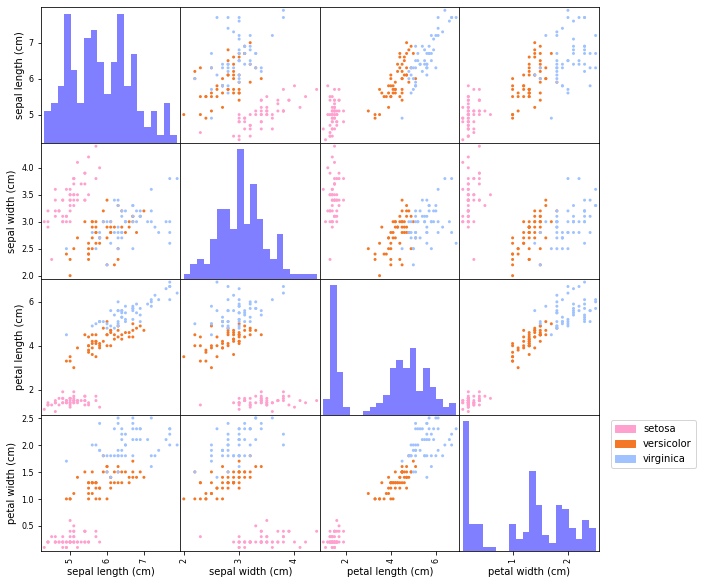

In [2]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
cm_bm = LinearSegmentedColormap.from_list("mycmapbm", ["#ffa1cf","#f37726","#a0c3ff"])
colors = np.array(["#ffa1cf", "#f37726", "#a0c3ff"])
color_array = colors[y].tolist()  # Map each row to its corresponding color


scatter_matrix(df, c =color_array, figsize=(10,10),  # c : color acording to classes
               hist_kwds={'color':'blue','bins':20, 'alpha':0.5}, alpha=1.)
# Legend
handles = [mpatches.Patch(color=colors[i], label=iris.target_names[i]) for i in range(len(iris.target_names))]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

We see that some feature pairs are more suitable than others in indicating how the classes could be separated. In particular sepal length vs. sepal length shows that the data can possibly be linearly separated. Most views also show that the _setosa_ class is more easy to separate from the other two classes.       
Every pair of features shows us a projection of the data onto two features.      
The question is if we can do better than plotting pairs of features. In principle we can generate new projections or views by generating our own features. For example, we could multiply features, or compute a weighted sum of the features. For example, the plot below shows a view of the data when plotting the sum of sepal length and width against the sum of petal length plus width.

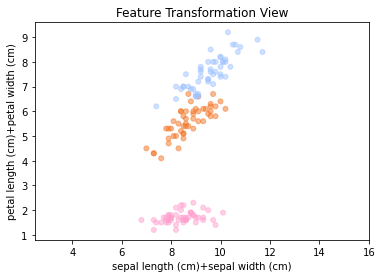

In [3]:
def plot(x_1,x_2, labels=None, title="", xlabel="x", ylabel="y"):
    if labels is None:
        plt.scatter(x_1, x_2, s=25, alpha=0.5, cmap=cm_bm)
    else:
        plt.scatter(x_1, x_2, c=labels, s=25, alpha=0.5, cmap=cm_bm)
    #plt.axhline(y=0, color='m', alpha=0.5)
    #plt.axvline(x=0, color='m', alpha=0.5)
    plt.axis('equal')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)


plot(D[:, 0]+D[:, 1], D[:,2]+D[:,3], y, title="Feature Transformation View", xlabel= iris.feature_names[0]+"+"+iris.feature_names[1], ylabel= iris.feature_names[2]+"+"+iris.feature_names[3])


This view already gives a good indication of how the data might be linearly separable. In this example, the two-dimensional projection provides useful insight into the separability of the classes. The key question is how to maximize the amount of information captured in such a low-dimensional view. To do this, we need a computable notion of _information_. To do so, we have a look at another example. 

#### Synthetic Data Example
For the Iris dataset, we tried to find a view that reflects well the data- and class-structure. However, we don't know if there is maybe a better view/projection of the data than the one we found. To get more clear on what our assumptions are about the data generation and what kind of structure we are looking for with PCA, we create synthetic data where we know what we put in and what we want to get out. We create a dataset that has a clear structure in 2 dimensions and then extend this data to three dimensions.

The two-dimensional dataset looks as follows:

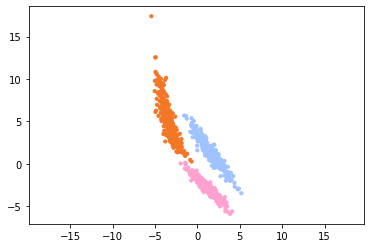

In [4]:
import numpy as np
def generate2dClassData(epsilon,n):
    # Anisotropicly distributed data
    A, labels = datasets.make_blobs(n_samples=n, cluster_std=epsilon*np.array([0.8,1.2,1.1]), random_state=176)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    A = np.dot(A, transformation)
    A[labels==1,1] = 0.1*A[labels==1,1]**2 
    angle = 10
    theta = (angle/180.) * np.pi

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta),  np.cos(theta)]])
    A[labels==1,:] = A[labels==1,:]@R
    angle = -10
    theta = (angle/180.) * np.pi

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta),  np.cos(theta)]])
    A[labels==0,:] = A[labels==0,:]@R
    return A, labels
n=1000
D2d, labels = generate2dClassData(1.5,n)
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
ax.scatter(D2d[:, 0], D2d[:, 1], c=labels, s=10, cmap=cm_bm)
plt.show()

We see that the classes, which have each their own color, are quite well separated. Now we extend this dataset to 3 dimensions by adding a third column to the dataset that is filled with Gaussian noise.

In [5]:
def plot3dProjections(D,labels):
    X=D[:,0]
    Y=D[:,1]
    Z=D[:,2]

    plt.figure( figsize=(13, 5))
    ax1 = plt.subplot(121,  projection='3d')

    ax1.scatter(X, Y, Z, c=labels, s=10, cmap=cm_bm)
    ax1.set_xlabel('X - axis')
    ax1.set_ylabel('Y - axis')
    ax1.set_zlabel('Z - axis')

    ax2 = plt.subplot(122,  projection='3d')

    cx = np.ones_like(X) * ax1.get_xlim3d()[0]
    cy = np.ones_like(X) * ax1.get_ylim3d()[1]
    cz = np.ones_like(Z) * ax1.get_zlim3d()[0]

    ax2.scatter(X, Y, cz, c=labels,  lw=0, alpha=0.2, cmap=cm_bm )
    ax2.scatter(X, cy, Z, c=labels, lw=0, alpha=0.2, cmap=cm_bm )
    ax2.scatter(cx, Y, Z, c=labels, lw=0, alpha=0.2, cmap=cm_bm)
    ax2.set_xlim3d(ax1.get_xlim3d())
    ax2.set_ylim3d(ax1.get_ylim3d())
    ax2.set_zlim3d(ax1.get_zlim3d())
    ax2.set_box_aspect([1.0, 1.0, 1.0])
    ax2.set_xlabel('X - axis')
    ax2.set_ylabel('Y - axis')
    ax2.set_zlabel('Z - axis')

In [6]:
def generate3dClassData(A,labels):
    s = np.random.normal(0, 0.8, A.shape[0])
    s[labels==2] = s[labels==2]*1.4 #class 2 noise has a higher variance
    A = np.hstack([A,s[:,None]])    
    return A, labels

D3d, labels = generate3dClassData(D2d,labels)

When we plot the data in a 3D plot together with the projections on each pair of features, we recognize our 2D data in the projection on the X-Y axis. 

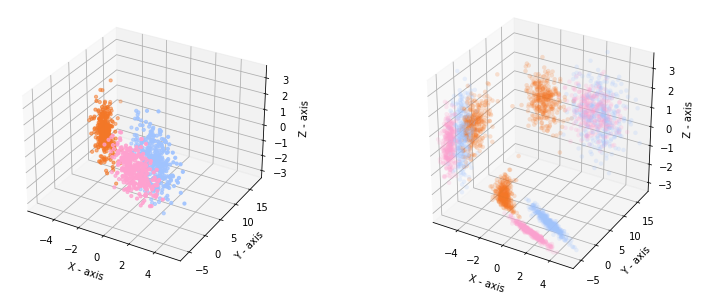

In [7]:
plot3dProjections(D3d,labels)

In general we cannot expect that the nicest view on the data is aligned with a selection of the axes. Hence, we rotate our 3D data to distort the two-dimensional views.

In [8]:
from scipy.spatial.transform import Rotation as Rt
D3d, labels = generate3dClassData(D2d,labels)
R = Rt.from_euler('zyx', [140, 145, 145], degrees=True)
D3d = D3d@R.as_matrix()

The 3D plot and the projections look now like this:

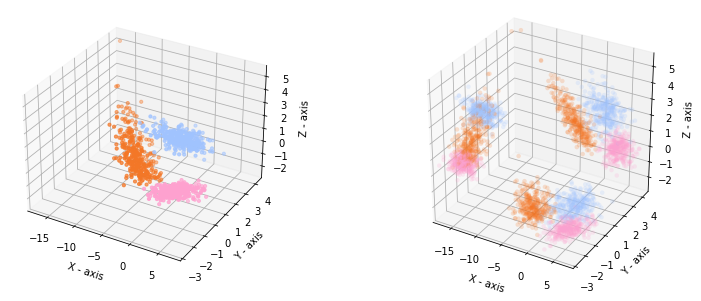

In [9]:
plot3dProjections(D3d,labels)

If we make a scatterplot matrix for the dataset, we get the following views. The data looks not so clearly separable anymore.

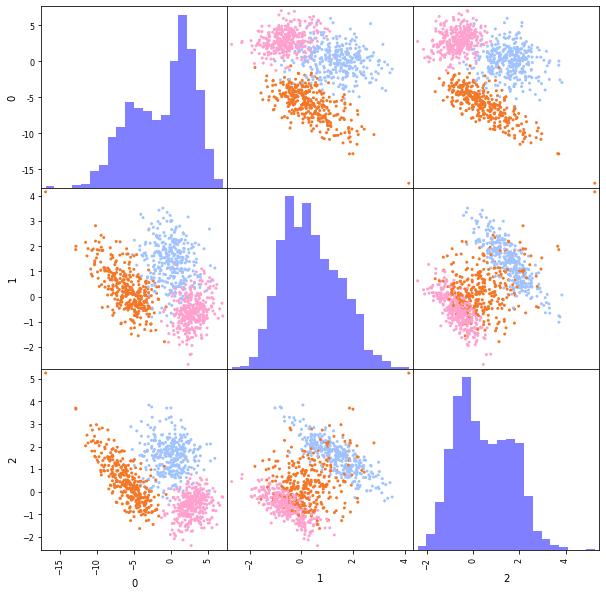

In [10]:
cm_bm = LinearSegmentedColormap.from_list("mycmapbm", ["#ffa1cf","#f37726","#a0c3ff"])
colors = np.array(["#ffa1cf", "#f37726", "#a0c3ff"])
color_array = colors[pd.DataFrame(labels)].squeeze()  # Map each row to its corresponding color


scatter_matrix(pd.DataFrame(D3d), c =color_array, figsize=(10,10),  # c : color acording to classes
               hist_kwds={'color':'blue','bins':20, 'alpha':0.5}, alpha=1.)
plt.show()

So, what we would like in this example is to find the direction along which we added the noise, and remove it, because this direction is not informative for the classification. Now the question is how we define the not-so informative directions. One way is to remove those directions along which not much is happening in the data. That are those directions along which the variance in the data is small. 

### Geometric View of PCA
Principal Component Analysis (PCA) can be understood geometrically as a way of projecting high-dimensional data onto a lower-dimensional subspace that captures the most variation in the data. A subspace is identified by a set of vectors, that forms the basis of the subspace. Each basis vector of the subspace indicates a direction in the original feature space onto which we project the data in the low-dimensional subspace view.      
#### Projection onto a Direction
Mathematically, a direction can be indicated by a vector. For example, the direction onto the Z-axis in our synthetic data example is given by the vector $(0,0,1)$. From the linear algebra recap, you might remember that a projection onto a vector is given by the inner product with a unit norm vector. That means that if we want to project our data onto a direction, then we need to multiply the data points with a unit vector pointing in that direction (unit vectors have norm one).     

Given the $n\times d$ data matrix $D$ gathering $n$ observations of $d$ features row-wise, the projection of all data points onto a direction indicated by vector $\bm\alpha$ is given by
\begin{align*}
\begin{pmatrix}
D_{1\cdot}\frac{\bm\alpha}{\lVert\bm\alpha\rVert}\\
\vdots\\
D_{n\cdot}\frac{\bm\alpha}{\lVert\bm\alpha\rVert}
\end{pmatrix}
=D \frac{\bm\alpha}{\lVert\bm\alpha\rVert}.
\end{align*}
The vector $D \frac{\bm\alpha}{\lVert\bm\alpha\rVert}$ can be interpreted as the values of a new feature, that is defined as the weighted sum of the existing features:
\begin{align}\tilde{\mathtt{x}}= \sum_{k=1}^d \frac{\alpha_k}{\lVert\bm\alpha\rVert}\mathtt{x}_k.\end{align}
The newly defined feature could now represent the first feature in our low-dimensional representation. The original $d$ features are transformed to $r$ new features over the projections of the data onto directions.       

Let's explore this by an example. We create an example dataset which has the shape of a multivariate Gaussian.

In [11]:
import numpy as np
mean = [10,5]
cov = [[20,10],[10,10]]
n=500

x1,x2 = np.random.multivariate_normal(mean,cov,n).T
D = np.c_[x1,x2]
dfD = pd.DataFrame(data =D,columns = ["$F_1$","$F_2$"])
dfD.head()

,$F_1$,$F_2$
0,10.752013,11.155914
1,9.195362,6.962050
2,6.912532,4.729937
3,2.034029,-1.510277
4,12.940890,4.840267


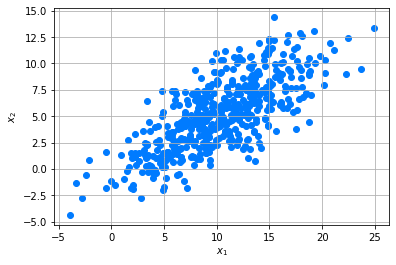

In [12]:
#define plotting environment
def pcaPlot(): 
    plt.axis('equal')
    plt.grid()
pcaPlot()

myblue = "#007bff"
plt.scatter(D[:,0],D[:,1], c=myblue)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

We choose vector $\alpha=(1,2)$, creating a new feature $\tilde{\mathtt{x}} = \frac{\alpha_1}{\lVert\bm\alpha\rVert}\mathtt{x}_1+\frac{\alpha_2}{\lVert\bm\alpha\rVert}\mathtt{x}_2$, having observations $D\frac{\bm\alpha}{\lVert\bm\alpha\rVert}$. 

In [13]:
α = np.array([1,2])
α=α/np.linalg.norm(α)
dfD_a = pd.DataFrame({"$\tilde{x}$":D@α})
dfD_a.head()

,$\tilde{x}$
0,14.786599
1,10.339338
2,7.321963
3,-0.441187
4,10.116608


We can compute the variance in the direction of $\bm\alpha$ as the variance of the new feature vector, that is created by projecting the data onto $\bm\alpha$:

In [14]:
np.var(D@α)

22.261052221159197

```{note}
Pandas computes the variance in a different way than numpy does. Pandas uses the unbiased estimator (dividing by $n-1$) and numpy the biased estimator (dividing by $n$). We use the variance estimation as provided by numpy.
```

We plot the data (blue), the projected data (orange), and the direction onto which $\alpha$ points (red). On the left we see how the data is projected onto the direction and on the right we see what a one-dimensional representation based on vector $\bm\alpha$ looks like.

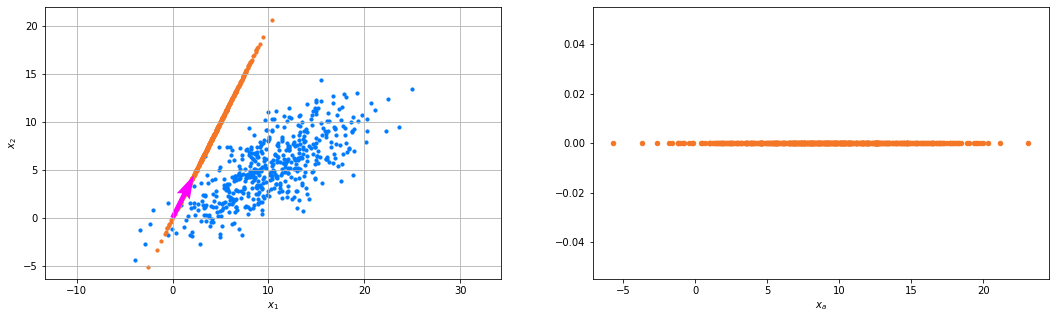

In [15]:
myorange = "#f37726"
myblue = "#007bff"
P = np.outer(D@α,α)/(np.linalg.norm(α)**2)
plt.figure(2, figsize=(18, 5))
#--------------
plt.subplot(1,2,1)
pcaPlot()
plt.scatter(D[:,0],D[:,1], s=10, color=myblue)
plt.scatter(P[:,0],P[:,1], color = myorange, s=10) 
plt.quiver(0, 0, 5*α[0],5*α[1] , units='xy', width=0.5, scale=1, color='magenta')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
#----------------
plt.subplot(1,2,2)
plt.scatter(D@α/np.linalg.norm(α), np.zeros(D.shape[0]), color =myorange, s=20)
plt.xlabel("$x_a$")
plt.show()

#### Variance as Information
We have discussed what a projection of the data onto a direction looks like. But how good is the vector $\bm\alpha$ that we chose? PCA assumes that directions with greater variance capture more _information_ about the structure of the data. In low-dimensional projections, we want to avoid collapsing meaningful differences between data points. The example data  follows a Gaussian multivariate distribution, that is defined over the variance in two directions. Of those two directions, the direction with higher variance is generally more meaningful, since this is the direction where _the most happens in the data_      

The animation below shows the projections onto the vector indicated in red in various directions. We see that the projected data spreads more (is longer) in some directions than in others. The projections resulting in long lines are those that we're looking for, those have a high variance.

In [16]:
#!pip3 install JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation
from IPython.display import HTML
def animatePCA(i):
    ax.cla()#clear axes
    ax.axis('equal')
    ax.grid()
    global α,D,R
    if i>0: α=R@α
    ax.scatter(D[:,0],D[:,1], s=10, color=myblue)
    P = np.outer(D@α,α)
    ax.scatter(P[:,0],P[:,1], color = myorange, s=10) 
    ax.quiver(0, 0, 10*α[0],10*α[1] , units='xy', width=0.5, scale=1, color='magenta')
    return
fig = plt.figure()
ax = plt.axes()
theta =np.pi/20
R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
α=np.array([1,0])
anim = animation.FuncAnimation(fig, animatePCA, frames=100, interval=200, blit=False)
plt.close()
HTML(anim.to_jshtml())

### Formal Definition of PCA
We define the task of PCA as the task to find a basis for a low-dimensional subspace that captures the most of the variance in the data. Basis vectors have to be orthogonal and we select them in the PCA task one by one in a greedy manner, according to the variance that they capture.   
`````{admonition} Task (Principle Component Analysis)
:class: tip
**Given** a data matrix $D\in\mathbb{R}^{n\times d}$ and a rank $r$, denoting the number of dimensions available for.       

**Find** the $r$ orthogonal direction of largest variance (called **principal components**), given by the columns $Z_{\cdot s}\in\mathbb{R}^d$ which are the solution to the following series of optimization problems:
\begin{align}
    \max_{Z_{\cdot 1}}\ & \mathrm{var}(DZ_{\cdot 1}) 
    \text{  s.t. } \lVert Z_{\cdot 1}\rVert^2=1\\
    \max_{Z_{\cdot 2}}\ & \mathrm{var}(DZ_{\cdot 2}) 
    \text{  s.t. } \lVert Z_{\cdot 2}\rVert^2=1,\ Z_{\cdot 1}^\top Z_{\cdot 2}=0 \\
    &\vdots\\
    \max_{Z_{\cdot r}}\ & \mathrm{var}(DZ_{\cdot r}) 
    \text{  s.t. } \lVert Z_{\cdot r}\rVert^2=1,\ Z_{\cdot s}^\top Z_{\cdot r}=0 \text{ for } 1\leq s< r\\
\end{align}
**Return** the directions of largest variance gathered as the columns of $Z$ 
`````

In order to understand how we can find the directions of maximum variance, we have a look how the variance $\mathrm{var}(D\vvec{z})$ is computed for a unit vector $\vvec{z}$.
```{prf:lemma}
:label: pca_var_prod
Given a data matrix $D\in\mathbb{R}^{n\times d}$. The variance of $D\vvec{z}$ is given as the squared norm of the centered data matrix multiplied with $\vvec{z}$:
\begin{align*}
\mathrm{var}(D\vvec{z}) = \frac1n\left\lVert \left(D -\vvec{1}{\bm \mu^\top }\right)\vvec{z}\right\rVert^2 = \frac1n\left\lVert C\vvec{z}\right\rVert^2. 
\end{align*}
The vector $\bm\mu = (\mu(D_{\cdot 1}),\ldots,\mu(D_{\cdot d}))$ is the mean vector of the data and the matrix $C=D -\vvec{1}{\bm \mu^\top} $ is the centered data matrix (the centered data points have mean zero).
```
````{toggle}
```{prf:proof}
 The variance is the squared deviation from the mean, and the sample mean is computed as  
\begin{align*}
    \mu(D\vvec{z}) &= \frac1n \sum_{i=1}^n D_{i\cdot}\vvec{z}
     = \sum_{k=1}^d \frac1n \sum_{i=1}^n  D_{ik}z_k\\
    & = \sum_{k=1}^d \mu(D_{\cdot k})z_k
    ={\bm \mu^\top \vvec{z}}.
\end{align*}
We compute the sample variance of the projected data as 
\begin{align*}
     \mathrm{var}(D\vvec{z})&=\frac1n\sum_{i=1}^n (D\vvec{z}-\mu(D\vvec{z}))^2
    =\frac1n\left\lVert \left(D -\vvec{1}{\bm \mu^\top }\right){\vvec{z}}\right\rVert^2
\end{align*}
```
````

```{prf:lemma}
:label: pca_obj_prod
The optimization objective
\begin{align*}
\max_{Z_{\cdot s}}\ \mathrm{var}(DZ_{\cdot s}) \text{ s.t. }\lVert Z_{\cdot s}\rVert=1,\ Z_{\cdot s}^\top Z_{\cdot q} \text{ for }1\leq q< s 
\end{align*}
is equivalent to
\begin{align*}
\max_{Z_{\cdot s}}\ Z_{\cdot s}^\top C^\top C Z_{\cdot s} \text{ s.t. }\lVert Z_{\cdot s}\rVert=1,\ Z_{\cdot s}^\top Z_{\cdot q} \text{ for }1\leq q< s 
\end{align*}
where $C$ is the centered data matrix (having mean zero).
```
````{toggle}
```{prf:proof}
According to {prf:ref}`pca_var_prod` the objective function is equal to
\begin{align*}
\mathrm{var}(DZ_{\cdot s}) =\frac1n\left\lVert CZ_{\cdot s}\right\rVert^2 = 
\frac1n Z_{\cdot s}^\top C^\top CZ_{\cdot s},
\end{align*}
If we want to maximize this objective, then we can drop the scaling with $1/n$ and we obtain the result.
```
````
The reformulation of the PCA objective according to the result above allows us to derive an optimization strategy.  

### Optimization
We approach the optimization challenge of the PCA task as it is described: one principal component at a time. 
```{prf:theorem}
:label: first_pca
Let $C\in\mathbb{R}^{n\times d}$ be a matrix, the solution of the objective
\begin{align*}
\max_{Z_{\cdot 1}}\ Z_{\cdot 1}^\top C^\top C Z_{\cdot 1} \text{ s.t. }\lVert Z_{\cdot 1}\rVert=1
\end{align*}
is given by the first right singular vector of $C$. That is, if $C=U\Sigma V^\top$ is the SVD, then the solution to the objective above is $Z_{\cdot 1}=V_{\cdot 1}$.
```
````{toggle}
```{prf:proof}
If $C=U\Sigma V^\top$ is the SVD of the centered data matrix $C$, then we have 
$$C^\top C= V\Sigma^\top U^\top U \Sigma V^\top = V\Sigma^\top \Sigma V^\top.$$
Since $V$ is an orthogonal matrix, $V^\top Z_{\cdot 1}$ is also a unit norm vector if $Z_{\cdot 1}$ has unit norm (the L2 norm is orthogonal invariant). Hence, finding a unit norm vector $Z_{\cdot 1}$ is equivalent to finding a unit norm vector that is composed as $\vvec{z}=V^\top Z_{\cdot 1}$. This way, we can rewrite the objective above as
\begin{align*}
&\max_{\vvec{z}}\ \vvec{z}^\top \Sigma^\top\Sigma \vvec{z} \text{  s.t. }\lVert \vvec{z}\rVert=1\\
&= \max_{\vvec{z}}\ \sigma_1^2 z_1^2 +\ldots +\sigma_d^2 z_d^2 \text{  s.t. }\lVert \vvec{z}\rVert=1.
\end{align*}
Since $\sigma_1$ is the largest singular value, the objective above is maximized if $z_1=1$ and all other coordinates being equal to zero, such that we satisfy the unit norm constraint. The solution vector $Z_{\cdot 1}$ of the original problem is then given by $Z_{\cdot 1}=V_{\cdot 1}$, because $V^\top V_{\cdot 1}=(1,0,\ldots,0)$.
```
````
According to {prf:ref}`pca_obj_prod`, the first principal component is given by the objective stated in {prf:ref}`first_pca`. As a result, the first principal component is given by the first right singular vector of the centered data matrix. 

```{prf:theorem}
:label: other_pcs
Let $C\in\mathbb{R}^{n\times d}$ be a matrix with SVD $C=U\Sigma V^\top$. The solution of the objective
\begin{align*}
\max_{Z_{\cdot s}}\ Z_{\cdot s}^\top C^\top C Z_{\cdot s} \text{ s.t. }\lVert Z_{\cdot s}\rVert=1,\ Z_{\cdot s}^\top V_{\cdot q}=0 \text{ for } 1\leq q < s 
\end{align*}
is given by the $s$th right singular vector of $C$: $Z_{\cdot s}=V_{\cdot s}$.
```
````{toggle}
```{prf:proof}
We follow the same steps as in the proof of {prf:ref}`first_pca` and define $\vvec{z}=V^\top Z_{\cdot s}$. Since we have $Z_{\cdot s}^\top V_{\cdot q}=0$ for $1\leq q < s$, the vector $\vvec{z}$ has a specific structure:
$$\vvec{z}=V^\top Z_{\cdot s} = (\underbrace{0,\ldots,0}_{s-1},Z_{\cdot s}^\top V_{\cdot s},\ldots ,Z_{\cdot s}^\top V_{\cdot d} ). $$
We rewrite the objective now using vector $\vvec{z}$
\begin{align*}
&\max_{\vvec{z}}\ \vvec{z}^\top \Sigma^\top\Sigma \vvec{z} \text{  s.t. }\lVert \vvec{z}\rVert=1, \\
&= \max_{\vvec{z}}\ \sigma_s^2 z_s^2 +\ldots +\sigma_d^2 z_d^2 \text{  s.t. }\lVert \vvec{z}\rVert=1 .
\end{align*}
Since $\sigma_s$ is the largest singular value, the objective above is maximized if $z_s=1$ and all other coordinates being equal to zero. The solution vector $Z_{\cdot 1}$ of the original problem is then given by $Z_{\cdot s}=V_{\cdot s}$, because $V^\top V_{\cdot s}=(\underbrace{0,\ldots,0}_{s-1},1,0,\ldots,0)$.
```
````
As a result, the solution to PCA is given by the truncated SVD. The principal components are given by $Z=V_{\cdot \mathcal{R}}$, where $\mathcal{R}=\{1,\ldots,r\}$ and $V$ is the right singular vector matrix of the centered data matrix. The principal components span the low-dimensional subspace that captures the most variance in the data. We project the data onto this subspace by multipling the data points or the centered data points with the principal components. The algorithm below details this relationship.
```{prf:algorithm} PCA
**Input**: $D, r$
1. $C\gets D-\vvec{1}{\bm\mu_\mathtt{x}^\top}$     #Center the data matrix
2. $(U_{\cdot \mathcal{R}},\Sigma_{\mathcal{R} \mathcal{R}},V_{\cdot \mathcal{R}})\gets$ `TruncatedSVD`$(C,r)$
3. **return** $CV_{\cdot \mathcal{R}}$   #the low-dimensional view on the data
```

PCA can be implemented such that the low-dimensional data representation is centered (returning $CV_{\cdot \mathcal{R}}$) or not (returning $DV_{\cdot \mathcal{R}}$).

### Alternative Views & Interpretations

#### PCA as an Eigenvalue Problem
The matrix $S=C^\top C$ is the empirical covariance matrix and finding the $s$th-principal component can hence also be stated as the task
\begin{align*}
\max_{Z_{\cdot s}}\ Z_{\cdot s}^\top S Z_{\cdot s} \text{ s.t. }\lVert Z_{\cdot s}\rVert=1,\ Z_{\cdot s}^\top Z_{\cdot q}=0 \text{ for } 1\leq q < s. 
\end{align*}
In this view, the principal components are given by the **eigenvectors** of the empirical covariance matrix $S$. The eigenvalues indicate how much variance is captured along each direction.
#### PCA as Trace Optimization
If we are not so much interested in finding the exactly ordered principal components, but more in the overall subspace that spans the low-dimensional representation of the data, we can apply the trace objective.
```{prf:theorem}
The matrix $Z$ that solves the objective below spans the low-dimensional subspace that is also spanned by the first $r$ principal components.
\begin{align}
    \max_{Z}&\ \tr(Z^\top C^\top C Z) & \text{s.t. } Z\in\mathbb{R}^{d\times r},\ Z^\top Z =I
\end{align}
where $C$ is the centered data matrix.
```
The trace maximization objective provides an opportunity to apply a kernel matrix instead of the empirical covariance matrix $C^\top C$. The corresponding objective is called **kernel PCA**. This allows to model also nonlinear relationships in the data, but the interpretation according to the captured variance of the data gets lost. 